In [17]:
#!pip install gymnasium control

import matplotlib
import numpy as np
from envsim.config import Config
matplotlib.rcParams['font.sans-serif'] = ['Heiti TC']
x0=np.array(Config.initial_state)


# ENV

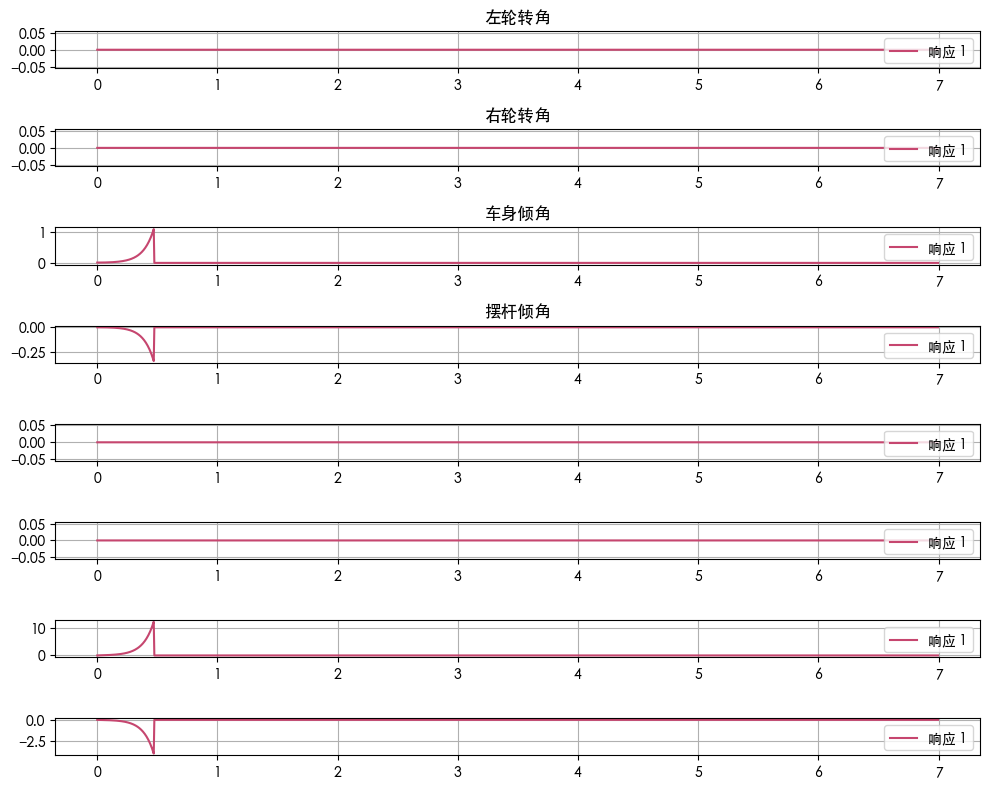

In [18]:
import matplotlib.pyplot as plt
import numpy as np
from env import BalancingCartEnv  
from vis import plot_system_outputs
# 创建环境
env = BalancingCartEnv()
obs, _ = env.reset(state=x0)

T = 7  # 仿真秒数
Ts = env.Ts
steps = int(T / Ts)

y_agent = np.zeros((steps, 8))

# 控制器（可以使用和前面一样的K，也可以先u=0模拟自由演化）
# 先用零输入模拟自由演化
K = np.zeros((2,8))  # 2x8的零矩阵替代之前的省略号
#K=np.array([[ 8.12694565e+01 -1.00616419e+01 -5.49240612e+03  1.89217098e+04   1.00363262e+02  8.03757851e+00  4.47308441e+02  2.96277380e+03] \
# [-1.00616419e+01  8.12694565e+01 -5.49240612e+03  1.89217098e+04   8.03757851e+00  1.00363262e+02  4.47308441e+02  2.96277380e+03]])
K[:2, :2] = np.array([[80.0, -10.0], [-10.0, 80.0]])  # 对称耦合增益
for i in range(steps):
    u = -K @ obs
    u=[0,0]
    obs, _, terminated, truncated, _ = env.step(u)
    y_agent[i, :] = obs
    if terminated or truncated:
        break
plot_system_outputs(y_agent,np.arange(0,T,Ts))



# LQR


系统可控！
[[ 8.12694565e+01 -1.00616419e+01 -5.49240612e+03  1.89217098e+04
   1.00363262e+02  8.03757851e+00  4.47308441e+02  2.96277380e+03]
 [-1.00616419e+01  8.12694565e+01 -5.49240612e+03  1.89217098e+04
   8.03757851e+00  1.00363262e+02  4.47308441e+02  2.96277380e+03]]
K_1 = [ 8.00000000e+01 -1.00000000e+01 -5.49240612e+03  1.89217098e+04
  1.00363262e+02  8.03757851e+00  4.47308441e+02  2.96277380e+03]
K_2 = [-1.00000000e+01  8.00000000e+01 -5.49240612e+03  1.89217098e+04
  8.03757851e+00  1.00363262e+02  4.47308441e+02  2.96277380e+03]


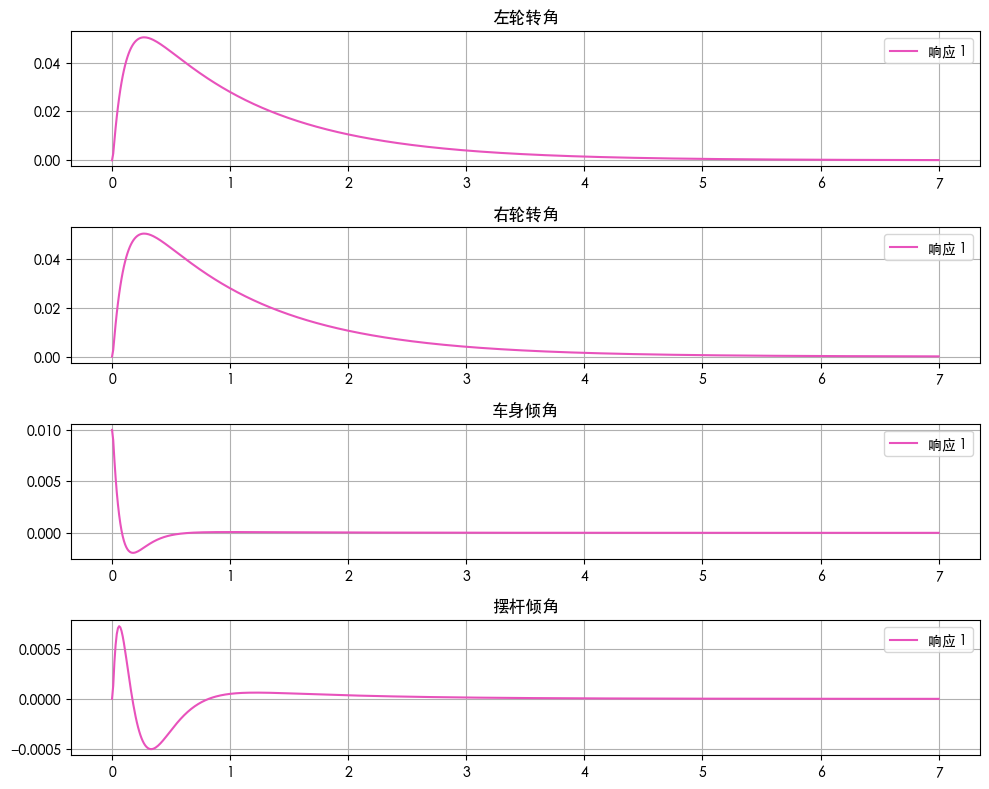

In [19]:
import numpy as np
import matplotlib
matplotlib.rcParams['font.sans-serif'] = ['Heiti TC']
import matplotlib.pyplot as plt
from scipy.linalg import inv
from control import c2d, dlqr, ss  # 需要安装control库: pip install control

# ==================== 物理参数定义 ====================
# 定义系统物理参数（单位：kg, m, rad等）
m_1 = 0.9      # 车体的质量
m_2 = 0.1      # 摆杆的质量
r = 0.0335     # 车轮的半径
L_1 = 0.126    # 车体的长度
L_2 = 0.390    # 摆杆的长度
l_1 = L_1 / 2  # 车体质心到转轴的距离
l_2 = L_2 / 2  # 摆杆质心到转轴的距离
g = 9.8        # 重力加速度

# 计算转动惯量（刚体绕质心的转动惯量公式）
I_1 = (1/12) * m_1 * L_1**2  # 车体转动惯量
I_2 = (1/12) * m_2 * L_2**2  # 摆杆转动惯量

# ==================== 系统建模 ====================
# 构建惯性矩阵 p (4x4矩阵)
p = np.array([
    [1, 0, 0, 0],
    [0, 1, 0, 0],
    [(r/2)*(m_1*l_1 + m_2*L_1), (r/2)*(m_1*l_1 + m_2*L_1), m_1*l_1**2 + m_2*L_1**2 + I_1, m_2*L_1*l_2],
    [(r/2)*m_2*l_2, (r/2)*m_2*l_2, m_2*L_1*l_2, m_2*l_2**2 + I_2]
])

# 构建重力/外力矩阵 q (4x10矩阵)
q = np.array([
    [0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
    [0, 0, (m_1*l_1 + m_2*L_1)*g, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, m_2*g*l_2, 0, 0, 0, 0, 0, 0]
])

# 计算临时矩阵 (p的逆乘以q)
temp = inv(p) @ q  # Python中使用@表示矩阵乘法

# ==================== 状态空间模型 ====================
# 构建A矩阵 (8x8状态矩阵)
A = np.vstack([
    np.hstack([np.zeros((4,4)), np.eye(4)]),  # 前4行
    temp[:, :8]                                # 后4行
])

# 构建B矩阵 (8x2控制输入矩阵)
B = np.vstack([
    np.zeros((4,2)),  # 前4行
    temp[:, 8:]       # 后4行
])

# 构建C矩阵 (4x8输出矩阵) - 假设观测所有位置状态
C = np.hstack([np.eye(4), np.zeros((4,4))])

# 构建D矩阵 (4x2前馈矩阵) - 通常为零
D = np.zeros((4,2))

# ==================== LQR控制器设计 ====================
Ts = 0.01  # 采样时间(s)
t = np.arange(0, 7+Ts, Ts)  # 时间向量
u = np.zeros((2, len(t)))    # 零输入信号

# 连续系统离散化
sys_c = ss(A, B, C, D)  # 创建连续状态空间系统
sys_d = c2d(sys_c, Ts, method='zoh')  # 离散化
G, H = sys_d.A, sys_d.B  # 获取离散状态空间矩阵

# 初始状态（含小扰动）

# 检查系统可控性
Tc = np.zeros((8,16))  # 可控性矩阵
for i in range(8):
    Tc[:, 2*i:2*(i+1)] = np.linalg.matrix_power(G, i) @ H

from vis import simulate_and_plot

if np.linalg.matrix_rank(Tc) == 8:
    print("系统可控！")
    
    # 定义LQR权重矩阵
    Q = np.diag([51.2938, 51.2938, 32.8281, 131.3123, 
                 51.2938, 51.2938, 131.3123, 131.3123])
    rho = 0.0005
    R = rho * np.eye(2)
    
    # 计算LQR增益矩阵
    K, _, _ = dlqr(G, H, Q, R)
    print(K)
    #K = np.zeros((2,8))  # 2x8的零矩阵替代之前的省略号
    K[:2, :2] = np.array([[80.0, -10.0], [-10.0, 80.0]])  # 对称耦合增益


    # 闭环系统仿真：系统是使用 状态反馈控制律 u_k = -Kx_k 来实现闭环控制的。
    G_cl = G - H @ K  # 闭环状态矩阵
    y = np.zeros((len(t), 4))  # 输出轨迹


        # 打印控制增益
    print("K_1 =", K[0,:])
    print("K_2 =", K[1,:])
    
    # 时域仿真
    simulate_and_plot(x0,t,G_cl,H,u,C)


else:
    print("系统不可控！")

    

系统可控！
[[ 8.12694565e+01 -1.00616419e+01 -5.49240612e+03  1.89217098e+04
   1.00363262e+02  8.03757851e+00  4.47308441e+02  2.96277380e+03]
 [-1.00616419e+01  8.12694565e+01 -5.49240612e+03  1.89217098e+04
   8.03757851e+00  1.00363262e+02  4.47308441e+02  2.96277380e+03]]
K_1 = [ 8.00000000e+01 -1.00000000e+01 -5.49240612e+03  1.89217098e+04
  1.00363262e+02  8.03757851e+00  4.47308441e+02  2.96277380e+03]
K_2 = [-1.00000000e+01  8.00000000e+01 -5.49240612e+03  1.89217098e+04
  8.03757851e+00  1.00363262e+02  4.47308441e+02  2.96277380e+03]


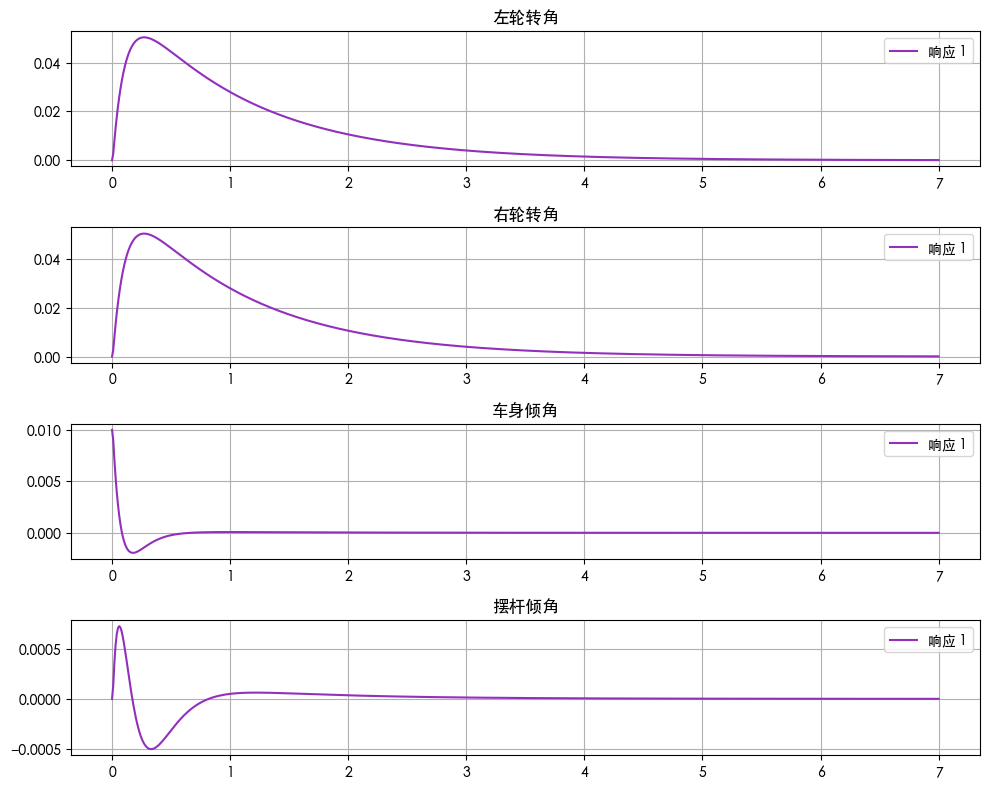

In [20]:

# ==================== LQR控制器设计 ====================
Ts = 0.01  # 采样时间(s)
t = np.arange(0, 7+Ts, Ts)  # 时间向量
u = np.zeros((2, len(t)))    # 零输入信号

# 连续系统离散化
sys_c = ss(A, B, C, D)  # 创建连续状态空间系统
sys_d = c2d(sys_c, Ts, method='zoh')  # 离散化
G, H = sys_d.A, sys_d.B  # 获取离散状态空间矩阵

# 初始状态（含小扰动）

# 检查系统可控性
Tc = np.zeros((8,16))  # 可控性矩阵
for i in range(8):
    Tc[:, 2*i:2*(i+1)] = np.linalg.matrix_power(G, i) @ H

from vis import simulate_and_plot

if np.linalg.matrix_rank(Tc) == 8:
    print("系统可控！")
    
    # 定义LQR权重矩阵
    Q = np.diag([51.2938, 51.2938, 32.8281, 131.3123, 
                 51.2938, 51.2938, 131.3123, 131.3123])
    rho = 0.0005
    R = rho * np.eye(2)
    
    # 计算LQR增益矩阵
    K, _, _ = dlqr(G, H, Q, R)
    print(K)
    #K = np.zeros((2,8))  # 2x8的零矩阵替代之前的省略号
    K[:2, :2] = np.array([[80.0, -10.0], [-10.0, 80.0]])  # 对称耦合增益


    # 闭环系统仿真：系统是使用 状态反馈控制律 u_k = -Kx_k 来实现闭环控制的。
    G_cl = G - H @ K  # 闭环状态矩阵
    y = np.zeros((len(t), 4))  # 输出轨迹


        # 打印控制增益
    print("K_1 =", K[0,:])
    print("K_2 =", K[1,:])
    
    # 时域仿真
    simulate_and_plot(x0,t,G_cl,H,u,C)


else:
    print("系统不可控！")

    

# simENV

系统可控性分析: 系统是完全可控的(秩=8)
计算得到的LQR增益矩阵 K: [[ 8.12706293e+01 -1.00604691e+01 -9.76825348e+03  2.31571666e+04
   1.00303833e+02  7.97814964e+00 -2.94638185e+02  3.67986310e+03]
 [-1.00604691e+01  8.12706293e+01 -9.76825348e+03  2.31571666e+04
   7.97814964e+00  1.00303833e+02 -2.94638185e+02  3.67986310e+03]]


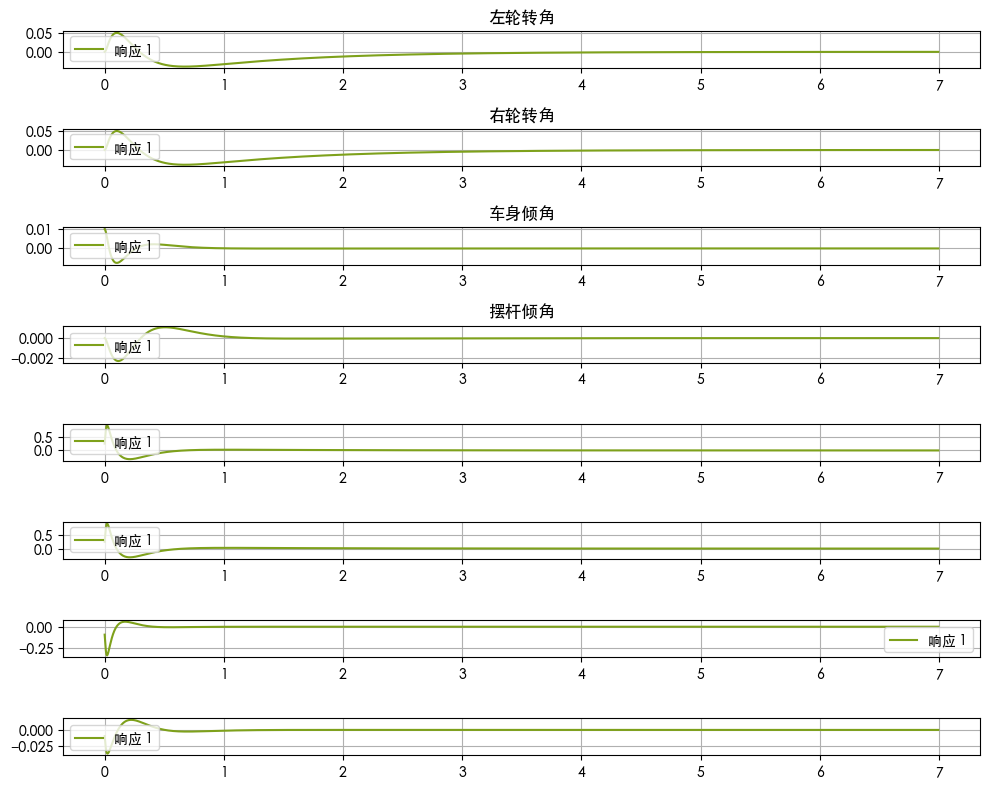

In [21]:
from envsim.lqr_controller import LQRController
from envsim.simulator import UnicycleSimulator
from envsim.config import Config
from vis import plot_system_outputs
# 闭环系统仿真：系统是使用 状态反馈控制律 u_k = -Kx_k 来实现闭环控制的。
Ts=Config.dt
t_simlqr=np.arange(0,7,Ts)
y_simlqr = np.zeros((len(t), 4))  # 输出轨迹



controller = LQRController()
simulator = UnicycleSimulator(controller,None,x0)
y_simlqr=np.zeros((len(t_simlqr),8))
for i in range(len(t_simlqr)):
    simulator.step()
    y_simlqr[i,:] = simulator.state


plot_system_outputs(y_simlqr,t_simlqr)

# agent

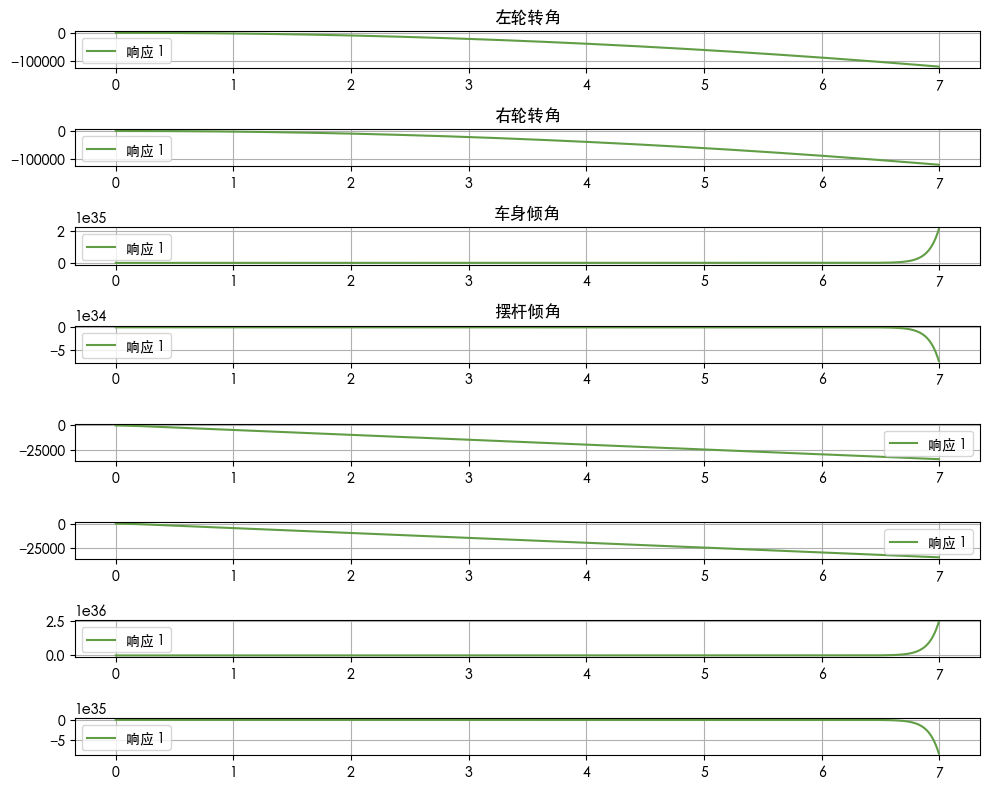

In [22]:
from env import BalancingCartEnv
from dqn_agent import DQNAgent
import os
import time
from configs import HIDDEN_SIZE,PATH
from vis import plot_training_results
env = BalancingCartEnv(render_mode=None)
agent = DQNAgent(env, hidden_size=HIDDEN_SIZE)
model_path = PATH
agent.load(model_path)
#test_env = BalancingCartEnv(render_mode='human')
state, _ = env.reset(state=x0)

T = 7  # 仿真秒数
Ts = env.Ts
steps = int(T / Ts)
y_agent = np.zeros((steps, 8))
t_agent=np.arange(0,T,Ts)

for i in range(steps):
    action = agent.act(state)
    continuous_action = agent.get_continuous_action(action)

    state, reward, terminated, truncated, _ = env.step(continuous_action)
    y_agent[i, :] = state
plot_system_outputs(y_agent,t_agent)


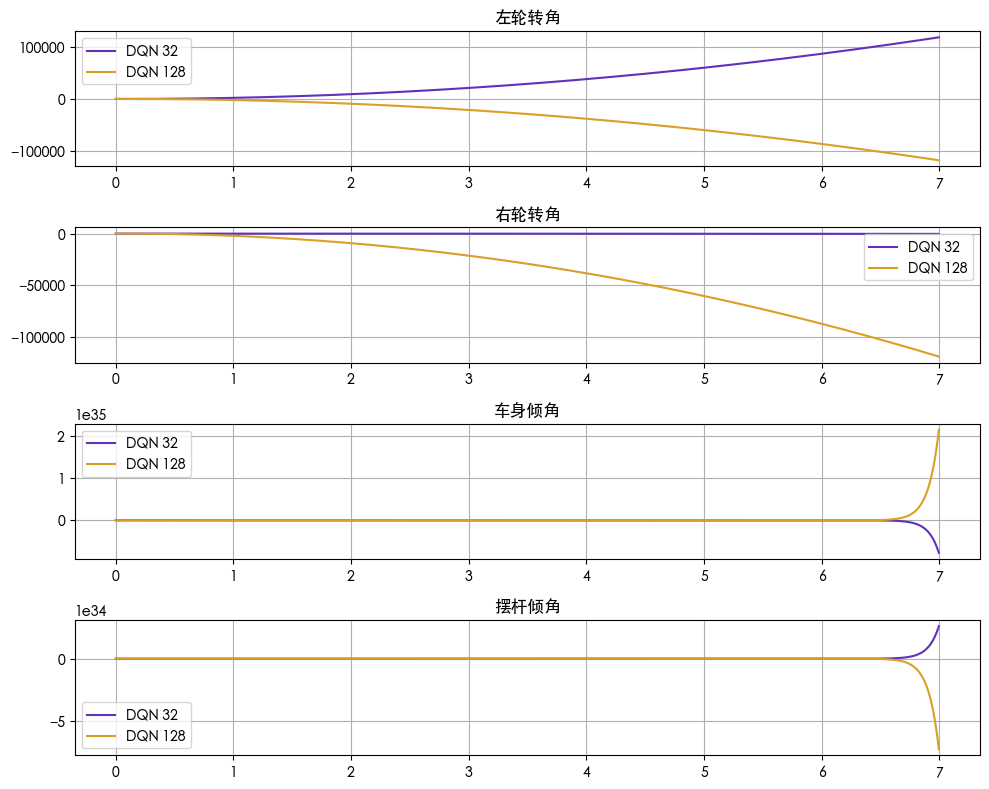

In [23]:
from env import BalancingCartEnv
from dqn_agent import DQNAgent
import os
import time
from vis import plot_training_results
from configs import HIDDEN_SIZES, PATHS

ys = []
ts = []
titles = []
ii=0
for HIDDEN_SIZE, PATH in zip(HIDDEN_SIZES, PATHS):
    ii=ii+1
    if ii==3: 
        break
    env = BalancingCartEnv(render_mode=None)
    agent = DQNAgent(env, hidden_size=HIDDEN_SIZE)
    model_path = PATH
    agent.load(model_path)
    state, _ = env.reset(state=x0)
    Ts = env.Ts
    steps = int(T / Ts)
    y_agent = np.zeros((steps, 8))
    t_agent = np.arange(0, T, Ts)

    for i in range(steps):
        action = agent.act(state)
        continuous_action = agent.get_continuous_action(action)
        state, reward, terminated, truncated, _ = env.step(continuous_action)
        y_agent[i, :] = state
    ys.append(y_agent)
    ts.append(t_agent)
    titles.append(f"DQN {HIDDEN_SIZE}")

from vis import plot_system_outputs
plot_system_outputs(ys, ts, titles=titles,n_subplots=4)


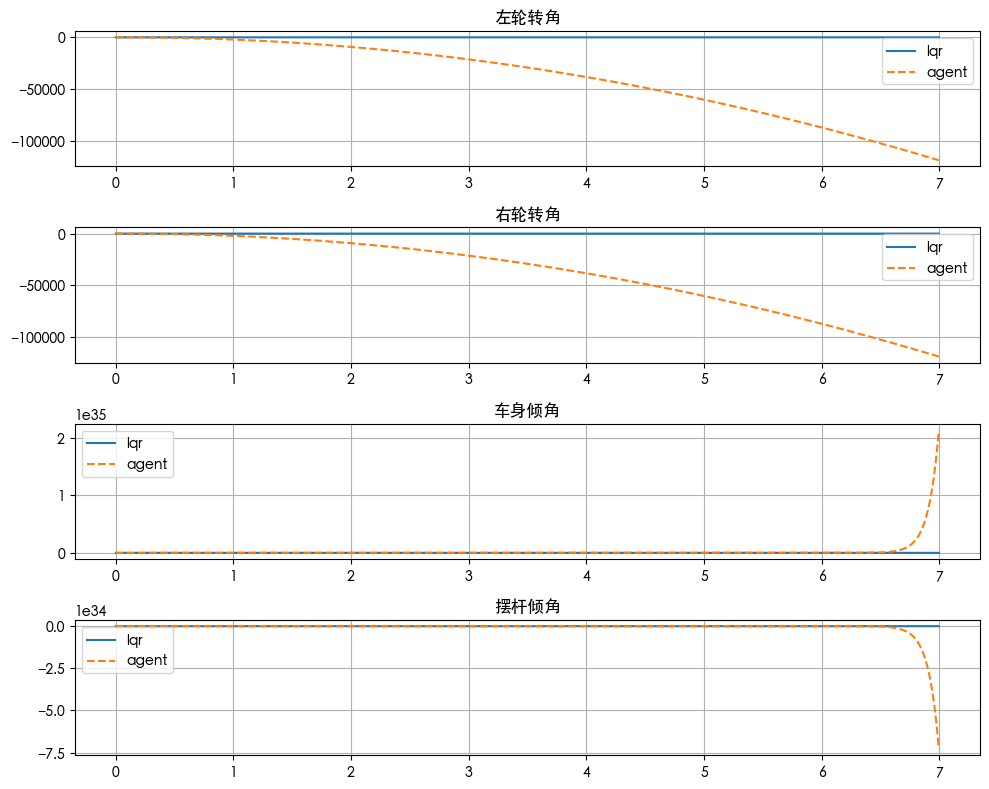

In [24]:
ty=[(t_simlqr,y_simlqr),(t_agent,y_agent)]
from vis import plot_from_t_y_pairs
plot_from_t_y_pairs(ty,   titles=['lqr', 'agent'],
    line_styles=['-', '--'],
    n_subplots=4)